Following the instructions in Hugging Face: https://huggingface.co/learn/diffusion-course/en/unit2/3

# Loading libraries and preparing the dataset

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 523kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 0, 1, 3, 5, 3, 4, 0])


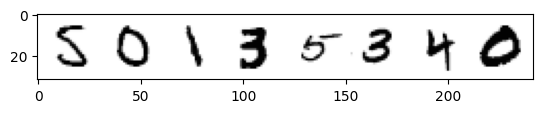

In [ ]:
# Loading the dataset
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# Example:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Creating a Class-Conditioned UNet

In [ ]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=28,  # image resolution
            in_channels=1 + class_emb_size,  # Additional input channels for class labels
            out_channels=1,
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # the forward method takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # embedded the class labels and reshape
        class_cond = self.class_emb(class_labels)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # concatenate x and class cond together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

#Training

In [ ]:
# Creating a noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [ ]:
# dataloader with batch size 128
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 30

# unet model
net = ClassConditionedUnet().to(device)

# loss function
loss_fn = nn.MSELoss()

# optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping record of losses for later viewing
losses = []

In [ ]:
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # data preparing
        x = x.to(device) * 2 - 1  # mapped to (-1, 1)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Getting the model prediction
        pred = net(noisy_x, timesteps, y)

        # Calculating the loss
        loss = loss_fn(pred, noise)

        # Backprop and updating the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Storing the loss for plotting
        losses.append(loss.item())

    # Printing out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.052246


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.045798


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.043758


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.043152


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.040716


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.040432


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.039955


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039065


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.039531


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.039642


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 10. Average of the last 100 loss values: 0.039066


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 11. Average of the last 100 loss values: 0.038449


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 12. Average of the last 100 loss values: 0.038243


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 13. Average of the last 100 loss values: 0.037906


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 14. Average of the last 100 loss values: 0.038172


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 15. Average of the last 100 loss values: 0.038212


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 16. Average of the last 100 loss values: 0.037296


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 17. Average of the last 100 loss values: 0.037787


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 18. Average of the last 100 loss values: 0.037788


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 19. Average of the last 100 loss values: 0.037807


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 20. Average of the last 100 loss values: 0.037086


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 21. Average of the last 100 loss values: 0.037057


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 22. Average of the last 100 loss values: 0.037337


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 23. Average of the last 100 loss values: 0.036434


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 24. Average of the last 100 loss values: 0.036755


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 25. Average of the last 100 loss values: 0.036908


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 26. Average of the last 100 loss values: 0.036838


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 27. Average of the last 100 loss values: 0.036819


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 28. Average of the last 100 loss values: 0.036217


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 29. Average of the last 100 loss values: 0.035970


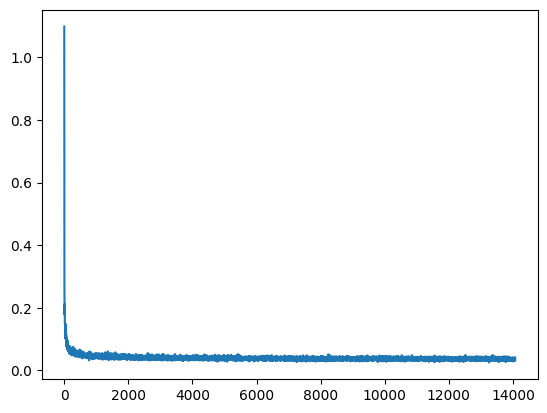

In [ ]:
# Plotting the loss curve
plt.plot(losses)

# Saving and loading the model

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'loss': loss,
}, "/content/drive/MyDrive/PIMA/ConditionalDiffuse/checkpoint.pt")

In [ ]:
checkpoint = torch.load( "/content/drive/MyDrive/PIMA/ConditionalDiffuse/checkpoint.pt")
net.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

# Sampling

0it [00:00, ?it/s]

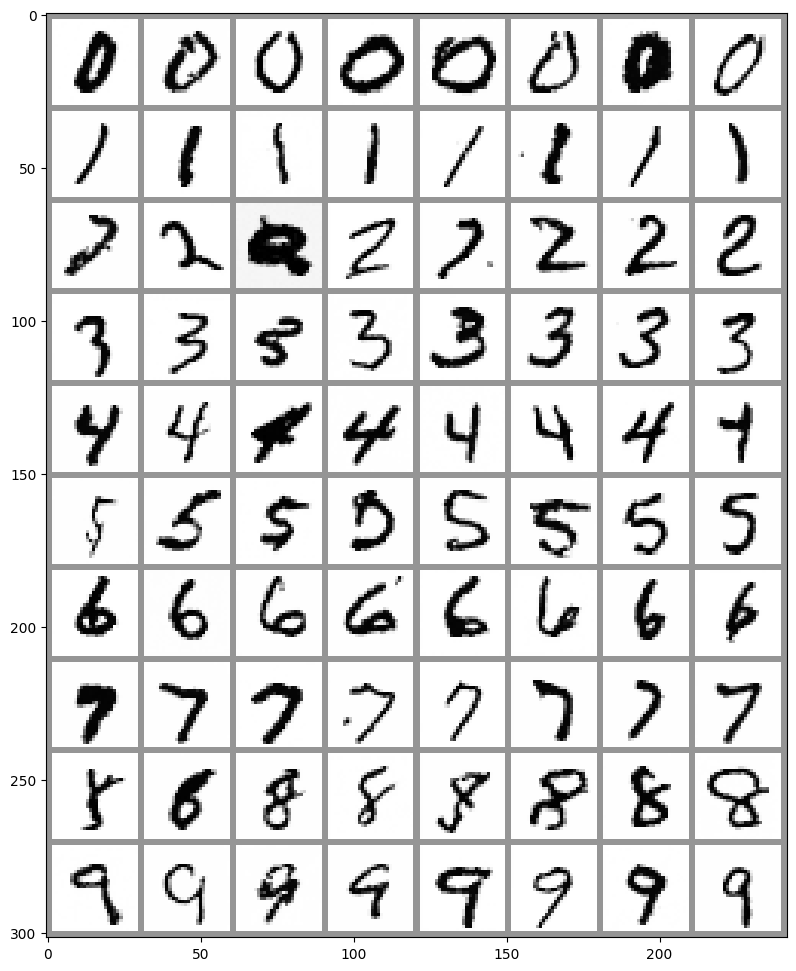

In [ ]:
# Preparing random x and labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)

    # Updating sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# plotting the result images
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

In this part, we want to generate image of digit 8 from the images of digit 3.

Number of 3s in batch: 6131


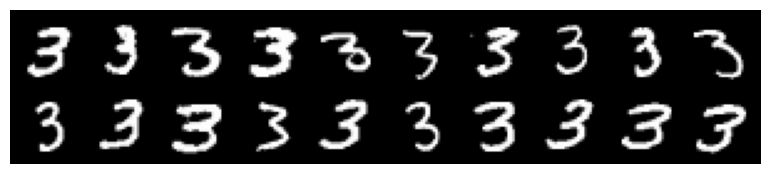

In [ ]:
# Getting images of digit 3
x = dataset.data
x = x.unsqueeze(1) # shape: (N, 1, 28, 28)
y = dataset.targets
x_label3 = x[y == 3]

print("Number of 3s in batch:", x_label3.shape[0])
import torchvision
import matplotlib.pyplot as plt

# displaying images of 3
grid = torchvision.utils.make_grid(x_label3[:20], nrow=10)
plt.figure(figsize=(10,2))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="Greys")
plt.axis("off")
plt.show()

Noised input shape: torch.Size([6131, 1, 28, 28])


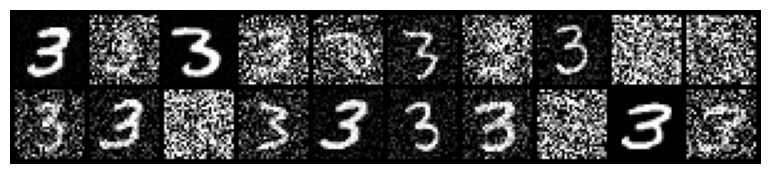

In [ ]:
# Noising all the images of 3 for sampling

x = x_label3.float().to(device) / 255.0  # changing value to range [0, 1]
x = x * 2 - 1                            # changing value to range [-1, 1]

noise = torch.randn_like(x.to(device))
timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

x = noisy_x
print("Noised input shape:", x.shape)

# displaying the noisy images of 3
grid = torchvision.utils.make_grid(((noisy_x + 1) / 2)[:20], nrow=10)
plt.figure(figsize=(10,2))
plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap="Greys")
plt.axis("off")
plt.show()

0it [00:00, ?it/s]

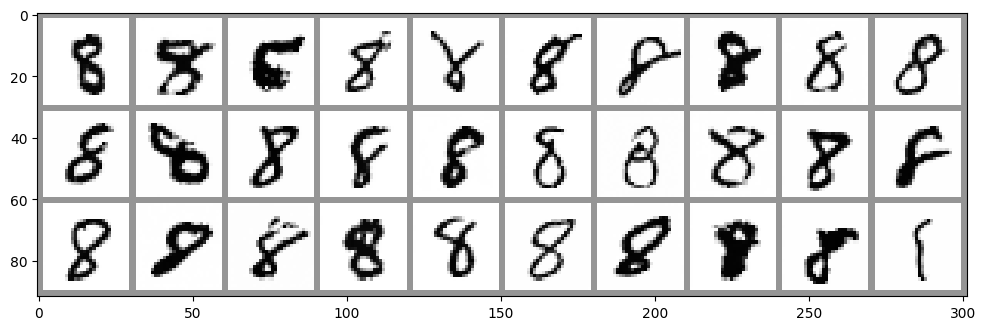

In [ ]:
# Generating image of 8 from image of 3
x = noisy_x.to(device)
# label y of 8 (same number of images of 3)
y = torch.tensor([8 for i in range(x_label3.shape[0])]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)

    # Updating the sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Displaying the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1)[:30], nrow=10)[0], cmap="Greys")

# Evaluation: Classifier and FID score
## Classifier

In [ ]:
# Loading the classifier model to evaluate
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/PIMA/Classifier/classifier_model.h5")

In [ ]:
# Converting from [-1, 1] to [0, 1] and moving to CPU numpy
images_np = ((x.detach().cpu().numpy() + 1) / 2).clip(0, 1)

# Reshaping from (N, 1, 28, 28) to (N, 784)
images_np = images_np.reshape(images_np.shape[0], 784)
images_np = images_np.astype('float32')
print("Input shape:", images_np.shape)

Input shape: (6131, 784)


In [ ]:
# Predicting
import numpy as np
predictions = model.predict(images_np)
predicted_labels = np.argmax(predictions, axis=1)

print("Predicted labels:", predicted_labels)

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted labels: [8 8 5 ... 8 8 8]


In [ ]:
# Getting the predicted labels' accuracy
N = len(predicted_labels)
true_labels = np.full(N, 8)
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 91.14%


### Confusion Matrix

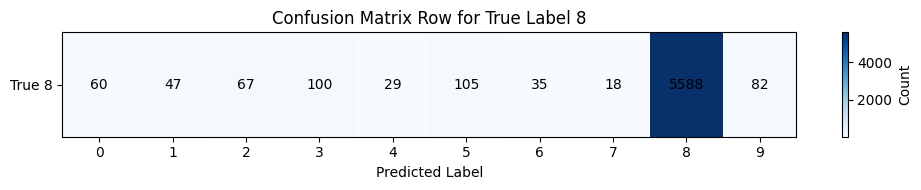

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Computing confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(10))

# Extracting row for true label 8
cm_row_8 = cm[8:9, :]

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))
im = ax.imshow(cm_row_8, cmap="Blues", aspect='auto')

for j in range(10):
    count = cm_row_8[0, j]
    ax.text(j, 0, str(count), ha="center", va="center", color="black")

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticks([0])
ax.set_yticklabels(["True 8"])
ax.set_xlabel("Predicted Label")
ax.set_title("Confusion Matrix Row for True Label 8")

plt.colorbar(im, ax=ax, orientation='vertical', label='Count')
plt.tight_layout()
plt.show()

## FID score

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

In [ ]:
import torch

from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T

# Initializing FID metric
fid = FrechetInceptionDistance(feature=64).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 127MB/s]


In [ ]:
# Adding real images to FID
for x, _ in train_dataloader:

    # Resizing to 299x299
    x = torch.nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

    # Converting to 3 channels
    x = x.repeat(1, 3, 1, 1)  # (B, 3, 299, 299)

    # Scaling to [0, 255] and convert to uint8
    x = (x * 255).clamp(0, 255).byte()

    # updating FID
    fid.update(x.to(device), real=True)

0it [00:00, ?it/s]

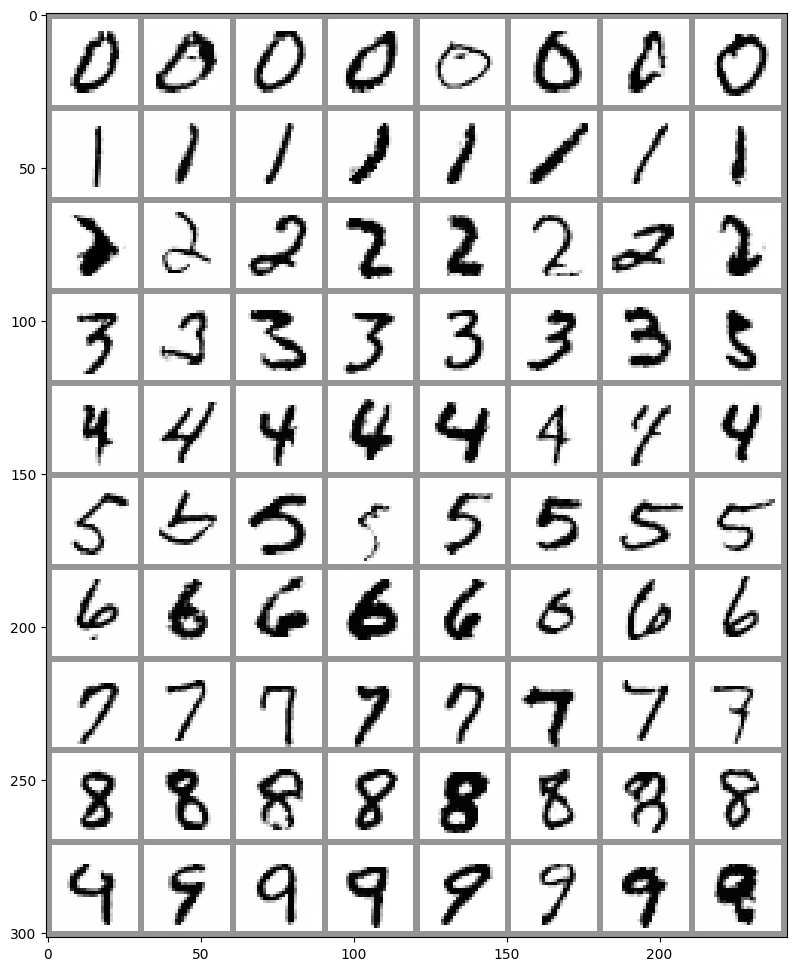

In [ ]:
# Preparing random x and labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)

    # Updating sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Showing the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

In [ ]:
x_fake = x.detach().cpu().clip(-1, 1)  # (N, 1, 28, 28)

# Converting to [0, 1] and to 3-channel with the resolution of 299x299
x_fake = (x_fake + 1) / 2
x_fake = torch.nn.functional.interpolate(x_fake, size=(299, 299))
x_fake = x_fake.repeat(1, 3, 1, 1)  # (N, 3, 299, 299)

# Scaling to [0, 255] and convert to uint8
x_fake = (x_fake * 255).clamp(0, 255).byte()

# Adding the generated images
fid.update(x_fake.to(device), real=False)

# Computing FID score
fid_score = fid.compute()
print(f"FID Score: {fid_score.item():.2f}")

FID Score: 1.39


FID = 0: perfect match (identical distributions)
Typical range:
- ≤10: excellent
- 10–50: okay
- 50: poor quality